In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#! pip install tqdm
from tqdm import tqdm

In [2]:
DATA_FOLDER='./data/'
PATHS_AND_GRAPH = DATA_FOLDER + 'wikispeedia_paths-and-graph/'
PATHS_FINISHED = PATHS_AND_GRAPH + 'paths_finished.tsv'
PATHS_UNFINISHED = PATHS_AND_GRAPH + 'paths_unfinished.tsv'

In [3]:
# loading finished paths
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [4]:
import os
os.listdir('./data')

['plaintext_articles',
 'wikispeedia_articles_html.tar.gz',
 'wikispeedia_articles_plaintext.tar.gz',
 'wikispeedia_paths-and-graph',
 'wikispeedia_paths-and-graph.tar.gz',
 'wpcd']

In [5]:
# loading unfinished paths
paths_unfinished= pd.read_csv(PATHS_UNFINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], encoding='utf-8', skiprows=17).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit='s')
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,2011-02-07 05:02:15,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,2011-02-07 05:14:11,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


###  

### Additional datasets needed for path_length metric

In [6]:
# Loading shortest path distance matrix 
SHORTEST_PATH_MATRIX = PATHS_AND_GRAPH + 'shortest-path-distance-matrix.txt'
shortest_path_distance_matrix= pd.read_csv(SHORTEST_PATH_MATRIX, sep='\t', names=['shortest path'], header=None, encoding='utf-8', skiprows=17).copy(deep=True)
shortest_path_distance_matrix = shortest_path_distance_matrix['shortest path'].apply(lambda x: list(x)) # splitting string into list
display(shortest_path_distance_matrix.head())

0    [0, _, _, _, _, _, 3, 3, 3, 3, 3, 3, 2, 5, 6, ...
1    [_, 0, _, _, _, _, 2, 2, 2, 2, 2, 3, 2, 5, 6, ...
2    [_, _, 0, _, _, _, 3, 3, 2, 2, 2, 4, 2, 5, 6, ...
3    [_, _, _, 0, _, _, 3, 3, 3, 3, 3, 3, 2, 5, 6, ...
4    [_, _, _, _, 0, _, 2, 2, 3, 2, 3, 3, 3, 5, 6, ...
Name: shortest path, dtype: object

In [7]:
# loading articles dataset
ARTICLES = PATHS_AND_GRAPH + 'articles.tsv'
articles= pd.read_csv(ARTICLES, sep='\t', header=None, encoding='utf-8', names=['article name'], skiprows=12).copy(deep=True)
display(articles.head())

,article name
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


## Path length metric: Are longer paths more challenging? Do they lead to giving up?
(Look at path length, ratings and giving up rate)

1) Removing mistakes from target column...
2) Removing back clicks and splitting paths...


100%|██████████████████████████████████████████████████████████████████████████| 51318/51318 [00:43<00:00, 1178.78it/s]


3) Computing optimal finished path length...


100%|███████████████████████████████████████████████████████████████████████████| 51318/51318 [00:55<00:00, 919.34it/s]


Mean optimal path length for finished games: 2.8454148641802095
4) Computing optimal unfinished path length...


100%|███████████████████████████████████████████████████████████████████████████| 24846/24846 [00:30<00:00, 809.45it/s]


Mean optimal path length for unfinished games: 3.2303791354745233
A longer optimal path length might cause more restarts and timouts, this is a metric we can further explore!
5) Plotting rating and finished path length...


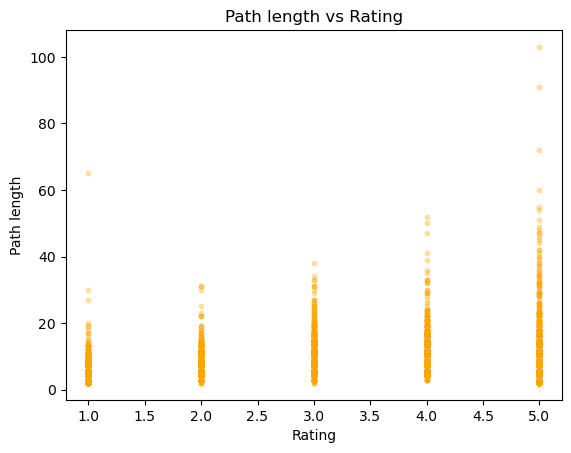

There seems to be a positive correlation between path length and rating. 
This is a metric we can potentially use after further testing and investigation.


In [8]:
# runtime = ~2min 

paths_finished_copy = paths_finished.copy(deep = True)
paths_unfinished_copy = paths_unfinished.copy(deep = True)
pd.options.mode.chained_assignment = None # to remove warning

# Delete datapoints from 'paths_unfinished_copy' if 'target' isn't part of article list from 'articles' dataframe
print('1) Removing mistakes from target column...')
paths_unfinished_copy = paths_unfinished_copy[paths_unfinished_copy['target'].isin(articles['article name'])]

# Removing back clicks (<) and splitting paths
print('2) Removing back clicks and splitting paths...')
for i in tqdm(range(len(paths_finished_copy))):
    paths_finished_copy['path'].iloc[i] = paths_finished_copy['path'].iloc[i].split(';')
    for item in paths_finished_copy['path'].iloc[i].copy():
        if (item == '<'):
            paths_finished_copy['path'].iloc[i].remove(item)


## Comparing optimal path length between finished and unfinished
print('3) Computing optimal finished path length...')
mean_finished_optimal_path_length = np.zeros((len(paths_finished_copy),1)) # change to only take unique path datapoints !!!
for i in tqdm(range(len(mean_finished_optimal_path_length))):
    start_article = paths_finished_copy['path'][i][0]
    end_article = paths_finished_copy['path'][i][-1]
    start_index = articles[articles['article name'] == start_article].index[0]
    end_index = articles[articles['article name'] == end_article].index[0]
    if shortest_path_distance_matrix[start_index][end_index] == '_' : 
        mean_finished_optimal_path_length[i] = -1
    else:
        mean_finished_optimal_path_length[i] = shortest_path_distance_matrix[start_index][end_index]
mean_finished_optimal_path_length =  mean_finished_optimal_path_length.mean()

print('Mean optimal path length for finished games:',mean_finished_optimal_path_length)

print('4) Computing optimal unfinished path length...')
mean_unfinished_optimal_path_length = np.zeros((len(paths_unfinished_copy),1))
for i in tqdm(range(len(mean_unfinished_optimal_path_length))):
    start_article = paths_unfinished_copy['path'].iloc[i].split(';')[0]
    end_article = paths_unfinished_copy['target'].iloc[i]
    start_index = articles[articles['article name'] == start_article].index[0]
    end_index = articles[articles['article name'] == end_article].index[0]
    if shortest_path_distance_matrix[start_index][end_index] == '_' :
        mean_unfinished_optimal_path_length[i] = -1                     # 'long peper' error !!!
    else:
        mean_unfinished_optimal_path_length[i] = shortest_path_distance_matrix[start_index][end_index]
mean_unfinished_optimal_path_length =  mean_unfinished_optimal_path_length.mean()

print('Mean optimal path length for unfinished games:', mean_unfinished_optimal_path_length)
print('A longer optimal path length might cause more restarts and timouts, this is a metric we can further explore!')


# Exploring possible correlation between rating and finished path length 
print('5) Plotting rating and finished path length...')
# Remove nans from the 'rating' columns
paths_finished_copy_woNan = paths_finished_copy.dropna(subset=["rating"]) 
# Remove aberrant path length value
paths_finished_copy_woNan = paths_finished_copy_woNan[paths_finished_copy_woNan['path'].apply(lambda x: len(x) <= 200)] 

plt.scatter(paths_finished_copy_woNan['rating'], paths_finished_copy_woNan['path'].apply(lambda x: len(x)), alpha = 0.3, s = 10, color = 'orange')
plt.ylabel('Path length')
plt.xlabel('Rating')
plt.title('Path length vs Rating')
plt.show()

print('There seems to be a positive correlation between path length and rating. \nThis is a metric we can potentially use after further testing and investigation.')

## 

## Link position metric:  Find position of clicked link on article page
Find word count to link on html page for second element in successive_pairs in first elements html page 

1) Removing back clicks and splitting paths...


100%|██████████████████████████████████████████████████████████████████████████| 51318/51318 [00:39<00:00, 1284.45it/s]


2) Computing position for every successive pair in finished paths...


100%|██████████████████████████████████████████████████████████████████████████| 51318/51318 [00:39<00:00, 1310.91it/s]


3) Comparing whether next clicked link is under or over threshold...
Under threshold count: 94868 
Over threshold count: 77201


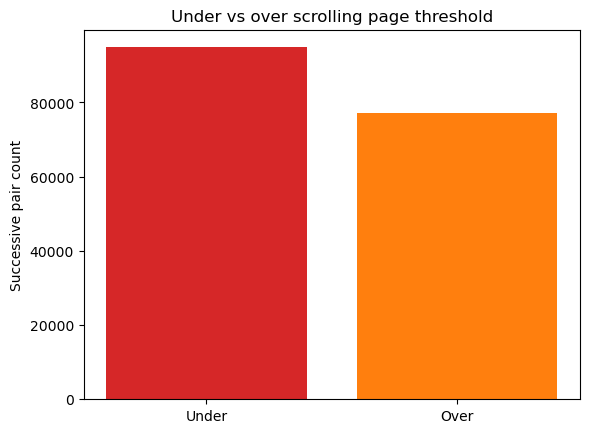

We can defenitely use this page position metric! 
The majority of players seams to not scroll to much before clicking on the next link.
4) Better metric: looking at character count before clicked link for every edge or for every player...


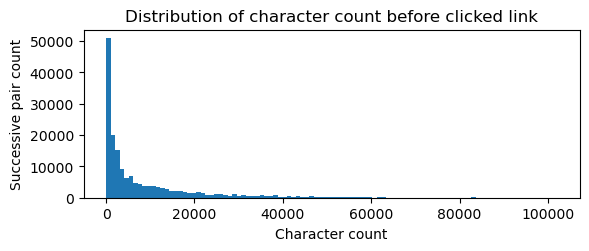

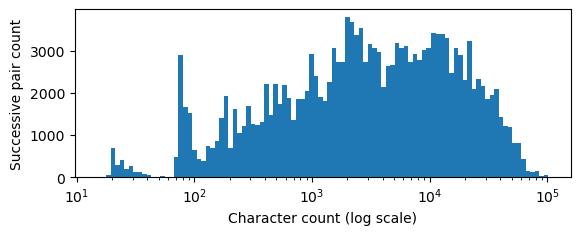

It is worth it to further investigate this metric, and see how it relates to good players. 
Also, it would be interesting to compare this metric in finished and unfinised games.


In [9]:
# runtime = ~1min30
paths_finished_copy = paths_finished.copy(deep = True)

# Removing back clicks (<) and splitting paths
print('1) Removing back clicks and splitting paths...')
for i in tqdm(range(len(paths_finished_copy))):
    paths_finished_copy['path'].iloc[i] = paths_finished_copy['path'].iloc[i].split(';')
    for item in paths_finished_copy['path'].iloc[i].copy():
        if (item == '<'):
            paths_finished_copy['path'].iloc[i].remove(item)

# Grouping successive pairs 
successive_pairs = [[(x[i], x[i+1]) for i in range(len(x) - 1)] for x in paths_finished_copy['path'].to_list()]

# Function that returns path to plaintext article
def path_to_plaintext(article_name):
    article_name_undsc = article_name.replace(" ", "_")
    ALL_PLAINTEXT = "./data/plaintext_articles/"
    path = ALL_PLAINTEXT + article_name_undsc + ".txt"
    return path 

# Function returning character count before clicked link of a sucessive pair (that is, position of second word in seccessive pair in first word in pair's article)
def find_word_position(successive_pair):
    target_words = successive_pair[1].replace("_", " ")
    article = path_to_plaintext(successive_pair[0])
    
    with open(article,encoding = "utf8") as file:
        content = file.read()
        try:
            return content.index(target_words)
        except: # Mistake because sometimes word in is html file but not in text file. To be treated later.
            #print(f"The group of words '{successive_pair[1]}' was not found in the file '{successive_pair[0]}'.") 
            return 0

# Computing maximum path length
path_length = paths_finished_copy['path'].apply(lambda x: len(x))
max_path_length = path_length.max()


# Compute position for every pair in finished paths
print('2) Computing position for every successive pair in finished paths...')
positions_of_next_clicked_link = np.zeros((len(successive_pairs), max_path_length - 1))
for i in tqdm(range(len(successive_pairs))):
    for j in range(len(successive_pairs[i])):
        positions_of_next_clicked_link[i,j] = find_word_position(successive_pairs[i][j])

# Computing average position of next clicked link
average_position = positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)].mean()


# Compare whether next clicked link is under or over threshold
print('3) Comparing whether next clicked link is under or over threshold...')
# Assuming a threshold of character count before word position
threshold = 4000  # try different ones maybe
under_threshold = np.count_nonzero(positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)] < threshold)
over_threshold = np.count_nonzero(positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)] > threshold)
print('Under threshold count:', under_threshold, '\nOver threshold count:', over_threshold)

groups = ['Under', 'Over']
counts = [under_threshold, over_threshold]
bar_colors = ['tab:red', 'tab:orange']
plt.bar(groups, counts, color=bar_colors)
plt.ylabel('Successive pair count')  # maybe aglomerate by players, not leave by successive pair count
plt.title('Under vs over scrolling page threshold')
plt.show()

print('We can defenitely use this page position metric! \nThe majority of players seams to not scroll to much before clicking on the next link.')



# Maybe a better metric: simply looking at the character count before clicked link 
print('4) Better metric: looking at character count before clicked link for every edge or for every player...')

# Histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)], bins = 100)
plt.title('Distribution of character count before clicked link')
plt.xlabel('Character count')
plt.ylabel('Successive pair count')
plt.show()

# Histogram on log scale
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins)) # Use non-equal bin sizes, such that they look equal on log scale.
plt.subplot(212)
plt.hist(positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)],bins=logbins)
plt.xscale('log')
plt.xlabel('Character count (log scale)')
plt.ylabel('Successive pair count')
plt.show()

print('It is worth it to further investigate this metric, and see how it relates to good players. \nAlso, it would be interesting to compare this metric in finished and unfinised games.')